In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from ROOT import TFile, TTree, TCanvas, TH2D
from scipy import constants
import pandas as pd
#plt.rcParams['text.usetex'] = True

from scipy.stats import binned_statistic_2d
import plotly.graph_objects as go

Welcome to JupyROOT 6.22/09


In [3]:
print(constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000)

0.93827208816


In [4]:
f = TFile("selectedEvents_011124.root","READ")
t = f.Get("selectedEvents")

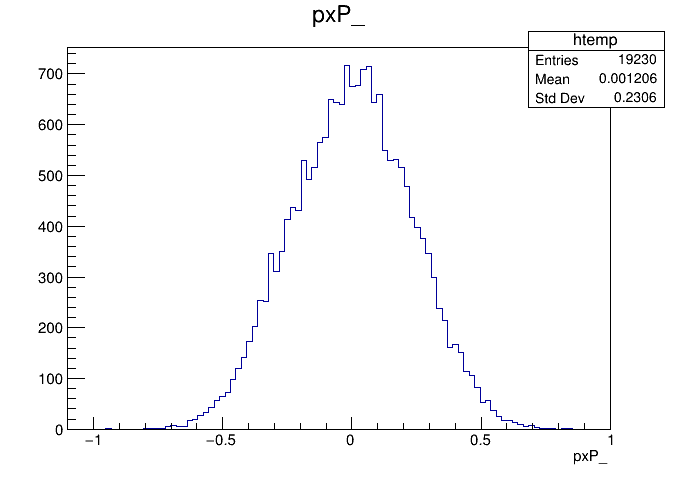

In [5]:
canvas = TCanvas("frNoSC","frNoSC",720,152,682,505)
canvas.cd()
#corr2 = TH2D("corr2","Fractional Difference vs. MCS Reco Momentum, no SC",100,0,2,100,0,2)
f.selectedEvents.Draw("pxP_","","COLZ")
#corr2.GetXaxis().SetTitle("MCS Reco Momentum, no SC [GeV]")
#corr2.GetYaxis().SetTitle("(MCS p (w/ SC) - MCS p (no SC)) / MCS p (no SC)")
canvas.Draw()

In [6]:
t.GetEntry(0)

def getTransverseAxis(eNu, pxMu, pyMu, pzMu):
    pV = np.array([0, 0, eNu])
    pMu = np.array([pxMu, pyMu, pzMu])
    z = np.cross(pV, pMu)
    magZ = np.sqrt( z[0]**2 + z[1]**2 + z[2]**2 )
    #return z / magZ
    return z / np.linalg.norm(z) # same as my magZ eqn above

print(t.eNu_)
print(t.pxMu_)

z = getTransverseAxis(t.eNu_,t.pxMu_,t.pyMu_,t.pzMu_)

print("z: ", z )
#testZ = np.array([ 0.04815974, -0.97140761, -0.23248202]) 

1.9261623620986938
0.029443029314279556
z:  [ 0.99614038  0.08777441 -0.        ]


In [7]:
print(t.modeNu_)
print(t.intrxnNu_)

1
1003


In [8]:
t.GetEntry(0)

pPi = np.array([t.pxPi_, t.pyPi_, t.pzPi_])
pP = np.array([t.pxP_, t.pyP_, t.pzP_])
print(pPi)
print(pP)

# 1st TKI observable, double-transverse momentum imbalance
def delPTT(z, pPi, pP): 
    pPiTT = np.dot(z,pPi)
    pPTT = np.dot(z,pP)
    return pPiTT + pPTT

print( delPTT(z, pPi, pP) )

[-0.19392665  0.00688269  0.25265351]
[0.18746324 0.32145506 0.31821021]
0.02238119136851674


In [9]:
t.GetEntry(0)
# sum of transverse momenta of the 3 particles
def delPT(pxPi, pxP, pxMu, pyPi, pyP, pyMu): 
    pTMu = np.array([pxMu, pyMu, 0])
    pTP = np.array([pxP, pyP, 0])
    pTPi = np.array([pxPi, pyPi, 0])
    return pTMu + pTPi + pTP

delPT_test = delPT(t.pxPi_, t.pxP_, t.pxMu_, t.pyPi_, t.pyP_, t.pyMu_)
print(delPT_test)

[ 0.02297962 -0.00580735  0.        ]


In [10]:
epsilon = 0.0309

# longitudinal component, the long way
def pL(pzP, pzMu, pzPi, eP, eMu, ePi, delPT): 
    mP = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    print("mP: ", mP)
    mN = constants.physical_constants['neutron mass energy equivalent in MeV'][0]/1000
    print("mN: ", mN)
    B = 0.34381
    mA = 22*mN + 18*mP - B
    mA1 = mA - mN + epsilon
    del2 = np.dot(delPT, delPT)
    #pLP = np.array([0, 0, pzP])
    #pLMu = np.array([0, 0, pzMu])
    #pLPi = np.array([0, 0, pzPi])
    parens = mA + pzMu + pzPi + pzP - eMu - ePi - eP
    return 0.5*(parens) - 0.5*((del2+mA1**2)/(parens))

pL_test = pL(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_, delPT_test)
print(t.pzP_)
print("pL_test: ", pL_test)

def pLGKI(pzP, pzMu, pzPi, eP, eMu, ePi):
    pRest = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000
    piRest = 139.57/1000 # GeV
    print("piRest:", piRest)
    #Ecal = eMu + (eP-pRest) + (ePi-piRest) + epsilon
    Ecal = eMu + (eP-pRest) + ePi + epsilon
    return pzMu + pzP + pzPi - Ecal

pLGKI_test = pLGKI(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_)
print("pLGKI_test: ", pLGKI_test)

mP:  0.93827208816
mN:  0.93956542052
0.3182102143764496
pL_test:  0.029933822501647
piRest: 0.13957
pLGKI_test:  0.028660566534481235


In [11]:
# 3rd TKI observable, boosting angle
def delAlphaT(pxMu, pyMu, delPT): 
    pTMu = np.array([pxMu, pyMu, 0])
    magPTMu = np.sqrt( pTMu[0]**2 + pTMu[1]**2 + pTMu[2]**2 )
    magDelPT = np.sqrt( delPT[0]**2 + delPT[1]**2 + delPT[2]**2 )
    dot = np.dot(-pTMu,delPT)
    return np.arccos(dot / (magPTMu * magDelPT))

delAlphaT_test = delAlphaT(t.pxMu_, t.pyMu_, delPT_test)
print(delAlphaT_test)

1.9062184509926832


In [12]:
# items to plot

muMom_list = []
piMom_list = []
lPMom_list = []
muAng_list = []
piAng_list = []
lPAng_list = []

delPTT_list = []
pL_list = []
pLGKI_list = []
pN_list = []
pNGKI_list = []
delAlphaT_list = []
mode_list = []
intrxn_list = []
recoNuE_list = []
weights_list = []

entries = t.GetEntries()

# main loop
for e in range(entries):

    t.GetEntry(e)
    
    pPi = np.array([t.pxPi_, t.pyPi_, t.pzPi_])
    pP = np.array([t.pxP_, t.pyP_, t.pzP_])
    
    z = getTransverseAxis(t.eNu_,t.pxMu_,t.pyMu_,t.pzMu_)
    delPT_entry = delPT(t.pxPi_, t.pxP_, t.pxMu_, t.pyPi_, t.pyP_, t.pyMu_)
    
    delPTT_list.append( delPTT(z, pPi, pP) )
    delAlphaT_list.append( delAlphaT(t.pxMu_, t.pyMu_, delPT_entry ) )
    
    pL_entry = pL(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_, delPT_test)
    pLGKI_entry = pLGKI(t.pzP_, t.pzMu_, t.pzPi_, t.eP_, t.eMu_, t.ePi_)
    
    pL_list.append( pL_entry )
    pLGKI_list.append( pLGKI_entry )
    
    pN = np.sqrt( np.dot(delPT_entry, delPT_entry) + np.dot(pL_entry, pL_entry) )
    pN_list.append(pN)
    
    pNGKI = np.sqrt( np.dot(delPT_entry, delPT_entry) + np.dot(pLGKI_entry, pLGKI_entry) )
    pNGKI_list.append(pNGKI)
    
    mode_list.append(t.modeNu_)
    intrxn_list.append(t.intrxnNu_)
    
    recoNuE_list.append(t.recoNuE_)
    
    muMom_list.append(t.muonMom_)
    piMom_list.append(t.pionMom_)
    lPMom_list.append(t.lProtonMom_)
    
    muAng_list.append(t.muonAng_)
    piAng_list.append(t.pionAng_)
    lPAng_list.append(t.lProtonAng_)
    
    weights_list.append(t.weight_)
    
    #print("pPi:", pPi)
    #print("pP:", pP)
    
#print("delPTT_list: ", delPTT_list)
print("delAlphaT_list: ", delAlphaT_list)
    
delPTT_arr = np.asarray(delPTT_list)
delAlphaT_arr = np.asarray(delAlphaT_list)
pL_arr = np.asarray(pL_list)
pLGKI_arr = np.asarray(pLGKI_list)
pN_arr = np.asarray(pN_list)
pNGKI_arr = np.asarray(pNGKI_list)
mode_arr = np.asarray(mode_list)
intrxn_arr = np.asarray(intrxn_list)
recoNuE_arr = np.asarray(recoNuE_list)
weights_arr = np.asarray(weights_list)

muMom_arr = np.asarray(muMom_list)
piMom_arr = np.asarray(piMom_list)
lPMom_arr = np.asarray(lPMom_list)
muAng_arr = np.asarray(muAng_list)
piAng_arr = np.asarray(piAng_list)
lPAng_arr = np.asarray(lPAng_list)
    

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93

mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
mP:  0.93827208816
mN:  0.93956542052
piRest: 0.13957
delAlphaT_list:  [1.9062184509926832, 1.9118402329549373, 2.6514036174622393, 2.094990616796469, 2.8274733566816677, 1.3593904941765191, 2.253023407019846, 2.640332253521577, 0.46666771721065675, 2.422389104263278, 2.4527823468643146, 2.940178767388513, 1.3880142613524336, 0.8432718134696019, 2.3193551598340685, 2.7763376865299243, 2.9640783610219885, 1.6958769914811471, 1.4084496807423101, 1.201608890379383, 2.5939572051171846, 1.913452729899137, 0.10937447390569578, 0.9125375827835598, 2.6348663636851968, 2.996307349880351, 2.9973651054119, 2.65543723464693, 3.1353287479317657, 2.8035353893125423, 2.956053884867644, 0.2833450171424536, 2.9023738937565327, 0.10472984021796443, 0.1348529464874933, 2.7122245306768016, 1.9

In [13]:
print("delPTT_arr.shape: ", delPTT_arr.shape)
print("delAlphaT_arr.shape: ", delAlphaT_arr.shape)
print("pL_arr.shape: ", pL_arr.shape)
print("pLGKI_arr.shape: ", pLGKI_arr.shape)
print("pN_arr.shape: ", pN_arr.shape)
print("pNGKI_arr.shape: ", pNGKI_arr.shape)
print("mode_arr.shape: ", mode_arr.shape)
print("intrxn_arr.shape: ", intrxn_arr.shape)

df = pd.DataFrame(
    {
        "delPTT": delPTT_arr,
        "delAlphaT": delAlphaT_arr,
        "mode": mode_arr,
        "intrxn": intrxn_arr
    }
)

print(df)

delPTT_arr.shape:  (19230,)
delAlphaT_arr.shape:  (19230,)
pL_arr.shape:  (19230,)
pLGKI_arr.shape:  (19230,)
pN_arr.shape:  (19230,)
pNGKI_arr.shape:  (19230,)
mode_arr.shape:  (19230,)
intrxn_arr.shape:  (19230,)
         delPTT  delAlphaT  mode  intrxn
0      0.022381   1.906218     1    1003
1      0.098047   1.911840     1    1004
2     -0.115950   2.651404     1    1003
3     -0.406683   2.094991     1    1003
4     -0.164166   2.827473     2    1091
...         ...        ...   ...     ...
19225  0.162693   2.181744     1    1005
19226  0.146319   2.740370     1    1003
19227  0.079395   2.692590     1    1003
19228 -0.127232   1.120418     1    1003
19229  0.021534   0.144314     1    1003

[19230 rows x 4 columns]


In [14]:
#dictionary of modes/intrxns
kNuanceOffset = 1000
intrxn_dict = {'QE':0, 'Res':1, 'DIS':2, 'Coh':3,
               'CCQE':kNuanceOffset+1, #charged current quasi-elastic
               'NCQE':kNuanceOffset+2, #neutral current quasi-elastic
               'ResCCNuProtonPiPlus':kNuanceOffset+3, #resonant charged current, nu p -> l- p pi+
               'ResCCNuNeutronPi0':kNuanceOffset + 4,      # resonant charged current, nu n -> l- n pi0
               'ResCCNuNeutronPiPlus':kNuanceOffset + 5,   # resonant charged current, nu n -> l- n pi+
               'ResNCNuProtonPi0':kNuanceOffset + 6,       # resonant neutral current, nu p -> nu p pi0
               'ResNCNuProtonPiPlus':kNuanceOffset + 7, # resonant neutral current, nu p -> nu p pi+
               'ResNCNuNeutronPi0':kNuanceOffset + 8,   # resonant neutral current, nu n -> nu n pi0
               'ResNCNuNeutronPiMinus':kNuanceOffset + 9,   # resonant neutral current, nu n -> nu p pi-
               'ResCCNuBarNeutronPiMinus':kNuanceOffset + 10,  # resonant charged current, nubar n -> l+ n pi-
               'ResCCNuBarProtonPi0':kNuanceOffset + 11,  # resonant charged current, nubar p -> l+ n pi0
               'ResCCNuBarProtonPiMinus':kNuanceOffset + 12,  # resonant charged current, nubar p -> l+ p pi-
               'ResNCNuBarProtonPi0':kNuanceOffset + 13,  # resonant charged current, nubar p -> nubar p pi0
               'ResNCNuBarProtonPiPlus':kNuanceOffset + 14,  # resonant charged current, nubar p -> nubar n pi+
               'ResNCNuBarNeutronPi0':kNuanceOffset + 15,  # resonant charged current, nubar n -> nubar n pi0
               'ResNCNuBarNeutronPiMinus':kNuanceOffset + 16,  # resonant charged current, nubar n -> nubar p pi-
               'ResCCNuDeltaPlusPiPlus':kNuanceOffset + 17,
               'ResCCNuDelta2PlusPiMinus':kNuanceOffset + 21,
               'ResCCNuBarDelta0PiMinus':kNuanceOffset + 28,
               'ResCCNuBarDeltaMinusPiPlus':kNuanceOffset + 32,
               'ResCCNuProtonRhoPlus':kNuanceOffset + 39,
               'ResCCNuNeutronRhoPlus':kNuanceOffset + 41,
               'ResCCNuBarNeutronRhoMinus':kNuanceOffset + 46,
               'ResCCNuBarNeutronRho0':kNuanceOffset + 48,
               'ResCCNuSigmaPlusKaonPlus':kNuanceOffset + 53,
               'ResCCNuSigmaPlusKaon0':kNuanceOffset + 55,
               'ResCCNuBarSigmaMinusKaon0':kNuanceOffset + 60,
               'ResCCNuBarSigma0Kaon0':kNuanceOffset + 62,
               'ResCCNuProtonEta':kNuanceOffset + 67,
               'ResCCNuBarNeutronEta':kNuanceOffset + 70,
               'ResCCNuKaonPlusLambda0':kNuanceOffset + 73,
               'ResCCNuBarKaon0Lambda0':kNuanceOffset + 76,
               'ResCCNuProtonPiPlusPiMinus':kNuanceOffset + 79,
               'ResCCNuProtonPi0Pi0':kNuanceOffset + 80,
               'ResCCNuBarNeutronPiPlusPiMinus':kNuanceOffset + 85,
               'ResCCNuBarNeutronPi0Pi0':kNuanceOffset + 86,
               'ResCCNuBarProtonPi0Pi0':kNuanceOffset + 90,
               'CCDIS':kNuanceOffset + 91,  # charged current deep inelastic scatter
               'NCDIS':kNuanceOffset + 92,  # charged current deep inelastic scatter
               'UnUsed1':kNuanceOffset + 93,
               'UnUsed2':kNuanceOffset + 94,
               'CCQEHyperon':kNuanceOffset + 95,
               'NCCOH':kNuanceOffset + 96,
               'CCCOH':kNuanceOffset + 97,  # charged current coherent pion
               'NuElectronElastic':kNuanceOffset + 98,  # neutrino electron elastic scatter
               'InverseMuDecay':kNuanceOffset + 99   # inverse muon decay
               
              }

print(intrxn_dict)
flip_dict = dict((v,k) for k,v in intrxn_dict.items())

print(flip_dict)

{'QE': 0, 'Res': 1, 'DIS': 2, 'Coh': 3, 'CCQE': 1001, 'NCQE': 1002, 'ResCCNuProtonPiPlus': 1003, 'ResCCNuNeutronPi0': 1004, 'ResCCNuNeutronPiPlus': 1005, 'ResNCNuProtonPi0': 1006, 'ResNCNuProtonPiPlus': 1007, 'ResNCNuNeutronPi0': 1008, 'ResNCNuNeutronPiMinus': 1009, 'ResCCNuBarNeutronPiMinus': 1010, 'ResCCNuBarProtonPi0': 1011, 'ResCCNuBarProtonPiMinus': 1012, 'ResNCNuBarProtonPi0': 1013, 'ResNCNuBarProtonPiPlus': 1014, 'ResNCNuBarNeutronPi0': 1015, 'ResNCNuBarNeutronPiMinus': 1016, 'ResCCNuDeltaPlusPiPlus': 1017, 'ResCCNuDelta2PlusPiMinus': 1021, 'ResCCNuBarDelta0PiMinus': 1028, 'ResCCNuBarDeltaMinusPiPlus': 1032, 'ResCCNuProtonRhoPlus': 1039, 'ResCCNuNeutronRhoPlus': 1041, 'ResCCNuBarNeutronRhoMinus': 1046, 'ResCCNuBarNeutronRho0': 1048, 'ResCCNuSigmaPlusKaonPlus': 1053, 'ResCCNuSigmaPlusKaon0': 1055, 'ResCCNuBarSigmaMinusKaon0': 1060, 'ResCCNuBarSigma0Kaon0': 1062, 'ResCCNuProtonEta': 1067, 'ResCCNuBarNeutronEta': 1070, 'ResCCNuKaonPlusLambda0': 1073, 'ResCCNuBarKaon0Lambda0': 1076,

In [15]:
#test = np.asarray(flip_dict.values())[np.searchsorted(flip_dict.keys(),intrxn_arr)]
#test = [flip_dict[i] for i in intrxn_arr]

In [16]:
#print(mode_list)
modeSet = set(mode_list)
print(modeSet)

{0, 1, 2, 10}


In [17]:
#print(intrxn_list)
myset = set(intrxn_list)
print(myset)

{1091, 1000, 1001, 1003, 1004, 1005}


In [18]:
# POT scaling!

targetPOT = 1.3e21
sumPOT = 8.98e20

scale = targetPOT / sumPOT
print("Scale is: ", scale)

print(np.sum(weights_arr))
totalEvents = np.sum(weights_arr)*scale
print("totalEvents: ", totalEvents)

Scale is:  1.447661469933185
19260.782968604184
totalEvents:  27883.093384393585


# In this section I grab the list of entries for each mode

In [19]:
modeZero_indices = []
modeOne_indices = []
modeTwo_indices = []
modeTen_indices = []

pN_modeZero = []
pN_modeOne = []
pN_modeTwo = []
pN_modeTen = []

weights_modeZero = []
weights_modeOne = []
weights_modeTwo = []
weights_modeTen = []

for index, item in enumerate(mode_arr):
    if item==0:
        modeZero_indices.append(index)
    if item==1:
        modeOne_indices.append(index)
    if item==2:
        modeTwo_indices.append(index)
    if item==10:
        modeTen_indices.append(index)
        
for index, item in enumerate(modeZero_indices):
    pN_modeZero.append(pN_arr[item])
    weights_modeZero.append(weights_arr[item])
    
for index, item in enumerate(modeOne_indices):
    pN_modeOne.append(pN_arr[item])
    weights_modeOne.append(weights_arr[item])
    
for index, item in enumerate(modeTwo_indices):
    pN_modeTwo.append(pN_arr[item])
    weights_modeTwo.append(weights_arr[item])

for index, item in enumerate(modeTen_indices):
    pN_modeTen.append(pN_arr[item])
    weights_modeTen.append(weights_arr[item])
    
pN_modeZero_arr=np.array(pN_modeZero)
print(len(pN_modeZero))
print(pN_modeZero_arr.shape)
print(len(weights_modeZero))
print("weights_modeZero:", weights_modeZero)

pN_modeOne_arr=np.array(pN_modeOne)
print(len(pN_modeOne))
print(pN_modeOne_arr.shape)
#print(len(weights_modeOne))
#print("weights_modeOne:", weights_modeOne)

modeTwo_indices_arr=np.array(modeTwo_indices)
print(len(modeTwo_indices))
print(modeTwo_indices_arr)
print(len(weights_modeTwo))
#print("weights_modeTwo:", weights_modeTwo)

modeTen_indices_arr=np.array(modeTen_indices)
print(len(modeTen_indices))
print(modeTen_indices_arr)
print(len(weights_modeTen))
#print("weights_modeTen:", weights_modeTen)

698
(698,)
698
weights_modeZero: [1.2415683269500732, 1.1661616563796997, 1.1498651504516602, 1.1794897317886353, 1.1529371738433838, 1.201310634613037, 1.1630046367645264, 1.1747409105300903, 1.2257769107818604, 1.1906055212020874, 1.1811673641204834, 1.1815273761749268, 1.2121648788452148, 1.204528570175171, 1.2010217905044556, 1.185013771057129, 1.1684821844100952, 1.2273085117340088, 1.1738097667694092, 1.1644339561462402, 1.1702754497528076, 1.2749860286712646, 1.1893540620803833, 1.2638815641403198, 1.1639533042907715, 1.1828101873397827, 1.1707627773284912, 1.226090431213379, 1.1823471784591675, 1.2596216201782227, 1.2613447904586792, 1.1203107833862305, 1.2376099824905396, 1.2306245565414429, 1.150436282157898, 1.1681350469589233, 1.3283048868179321, 1.2397639751434326, 1.2358545064926147, 1.2534226179122925, 1.1755577325820923, 1.2677106857299805, 1.196946144104004, 1.2312250137329102, 1.1726831197738647, 1.183571219444275, 1.2197781801223755, 1.233838677406311, 1.198624372482

In [20]:
delAlphaT_modeZero = []
delAlphaT_modeOne = []
delAlphaT_modeTwo = []
delAlphaT_modeTen = []

delAlphaT_deg = delAlphaT_arr*(180/np.pi)

for index, item in enumerate(modeZero_indices):
    delAlphaT_modeZero.append(delAlphaT_deg[item])
    
for index, item in enumerate(modeOne_indices):
    delAlphaT_modeOne.append(delAlphaT_deg[item])
    
for index, item in enumerate(modeTwo_indices):
    delAlphaT_modeTwo.append(delAlphaT_deg[item])

for index, item in enumerate(modeTen_indices):
    delAlphaT_modeTen.append(delAlphaT_deg[item])

delAlphaT_modeZero_arr=np.array(delAlphaT_modeZero)
print(len(delAlphaT_modeZero_arr))
print(delAlphaT_modeZero_arr.shape)
print(len(weights_modeZero))

698
(698,)
698


In [21]:
delPTT_modeZero = []
delPTT_modeOne = []
delPTT_modeTwo = []
delPTT_modeTen = []

for index, item in enumerate(modeZero_indices):
    delPTT_modeZero.append(delPTT_arr[item])
    
for index, item in enumerate(modeOne_indices):
    delPTT_modeOne.append(delPTT_arr[item])
    
for index, item in enumerate(modeTwo_indices):
    delPTT_modeTwo.append(delPTT_arr[item])

for index, item in enumerate(modeTen_indices):
    delPTT_modeTen.append(delPTT_arr[item])

# In this section I grab the list of entries for each intrxn

In [22]:
intrxnA_indices = []
intrxnB_indices = []
intrxnC_indices = []
intrxnD_indices = []
intrxnE_indices = []
intrxnF_indices = []

for index, item in enumerate(intrxn_arr):
    if item==1000:
        intrxnA_indices.append(index)
    if item==1001:
        intrxnB_indices.append(index)
    if item==1003:
        intrxnC_indices.append(index)
    if item==1004:
        intrxnD_indices.append(index)
    if item==1005:
        intrxnE_indices.append(index)
    if item==1091:
        intrxnF_indices.append(index)
        
intrxnA_indices_arr=np.array(intrxnA_indices)
print(len(intrxnA_indices))
print(intrxnA_indices_arr)

551
[   71    73    97   110   164   166   174   212   225   237   246   253
   299   313   402   462   488   549   563   641   682   720   784   798
   819   840   843   888   929   970   990   992  1014  1045  1053  1070
  1160  1213  1220  1288  1290  1304  1394  1412  1463  1625  1638  1667
  1708  1722  1723  1870  1895  1918  1938  2011  2037  2071  2083  2129
  2190  2192  2193  2233  2353  2480  2484  2550  2629  2673  2677  2743
  2839  2894  2916  2929  2958  3018  3029  3054  3129  3130  3165  3166
  3184  3199  3284  3331  3336  3373  3384  3451  3465  3481  3509  3523
  3604  3633  3643  3665  3703  3712  3726  3744  3769  3805  3821  3826
  3840  3868  3913  3937  3940  3960  4010  4020  4063  4066  4087  4120
  4138  4152  4154  4165  4264  4358  4370  4565  4634  4660  4671  4685
  4689  4739  4743  4747  4749  4905  5054  5122  5125  5157  5175  5197
  5206  5250  5253  5255  5264  5280  5287  5419  5421  5447  5573  5584
  5623  5628  5640  5648  5659  5707  5739  574

In [23]:
pN_intrxnA = []
pN_intrxnB = []
pN_intrxnC = []
pN_intrxnD = []
pN_intrxnE = []
pN_intrxnF = []

weights_intrxnA = []
weights_intrxnB = []
weights_intrxnC = []
weights_intrxnD = []
weights_intrxnE = []
weights_intrxnF = []

for index, item in enumerate(intrxnA_indices):
    pN_intrxnA.append(pN_arr[item])
    weights_intrxnA.append(weights_arr[item])
    
for index, item in enumerate(intrxnB_indices):
    pN_intrxnB.append(pN_arr[item])
    weights_intrxnB.append(weights_arr[item])

for index, item in enumerate(intrxnC_indices):
    pN_intrxnC.append(pN_arr[item])
    weights_intrxnC.append(weights_arr[item])
    
for index, item in enumerate(intrxnD_indices):
    pN_intrxnD.append(pN_arr[item])
    weights_intrxnD.append(weights_arr[item])
    
for index, item in enumerate(intrxnE_indices):
    pN_intrxnE.append(pN_arr[item])
    weights_intrxnE.append(weights_arr[item])
    
for index, item in enumerate(intrxnF_indices):
    pN_intrxnF.append(pN_arr[item])
    weights_intrxnF.append(weights_arr[item])
    


In [24]:
delAlphaT_intrxnA = []
delAlphaT_intrxnB = []
delAlphaT_intrxnC = []
delAlphaT_intrxnD = []
delAlphaT_intrxnE = []
delAlphaT_intrxnF = []

delAlphaT_deg = delAlphaT_arr*(180/np.pi)

for index, item in enumerate(intrxnA_indices):
    delAlphaT_intrxnA.append(delAlphaT_deg[item])
    
for index, item in enumerate(intrxnB_indices):
    delAlphaT_intrxnB.append(delAlphaT_deg[item])
    
for index, item in enumerate(intrxnC_indices):
    delAlphaT_intrxnC.append(delAlphaT_deg[item])
    
for index, item in enumerate(intrxnD_indices):
    delAlphaT_intrxnD.append(delAlphaT_deg[item])
    
for index, item in enumerate(intrxnE_indices):
    delAlphaT_intrxnE.append(delAlphaT_deg[item])
    
for index, item in enumerate(intrxnF_indices):
    delAlphaT_intrxnF.append(delAlphaT_deg[item])

In [25]:
delPTT_intrxnA = []
delPTT_intrxnB = []
delPTT_intrxnC = []
delPTT_intrxnD = []
delPTT_intrxnE = []
delPTT_intrxnF = []

for index, item in enumerate(intrxnA_indices):
    delPTT_intrxnA.append(delPTT_arr[item])
    
for index, item in enumerate(intrxnB_indices):
    delPTT_intrxnB.append(delPTT_arr[item])
    
for index, item in enumerate(intrxnC_indices):
    delPTT_intrxnC.append(delPTT_arr[item])
    
for index, item in enumerate(intrxnD_indices):
    delPTT_intrxnD.append(delPTT_arr[item])
    
for index, item in enumerate(intrxnE_indices):
    delPTT_intrxnE.append(delPTT_arr[item])
    
for index, item in enumerate(intrxnF_indices):
    delPTT_intrxnF.append(delPTT_arr[item])

# Plots!

<IPython.core.display.Javascript object>


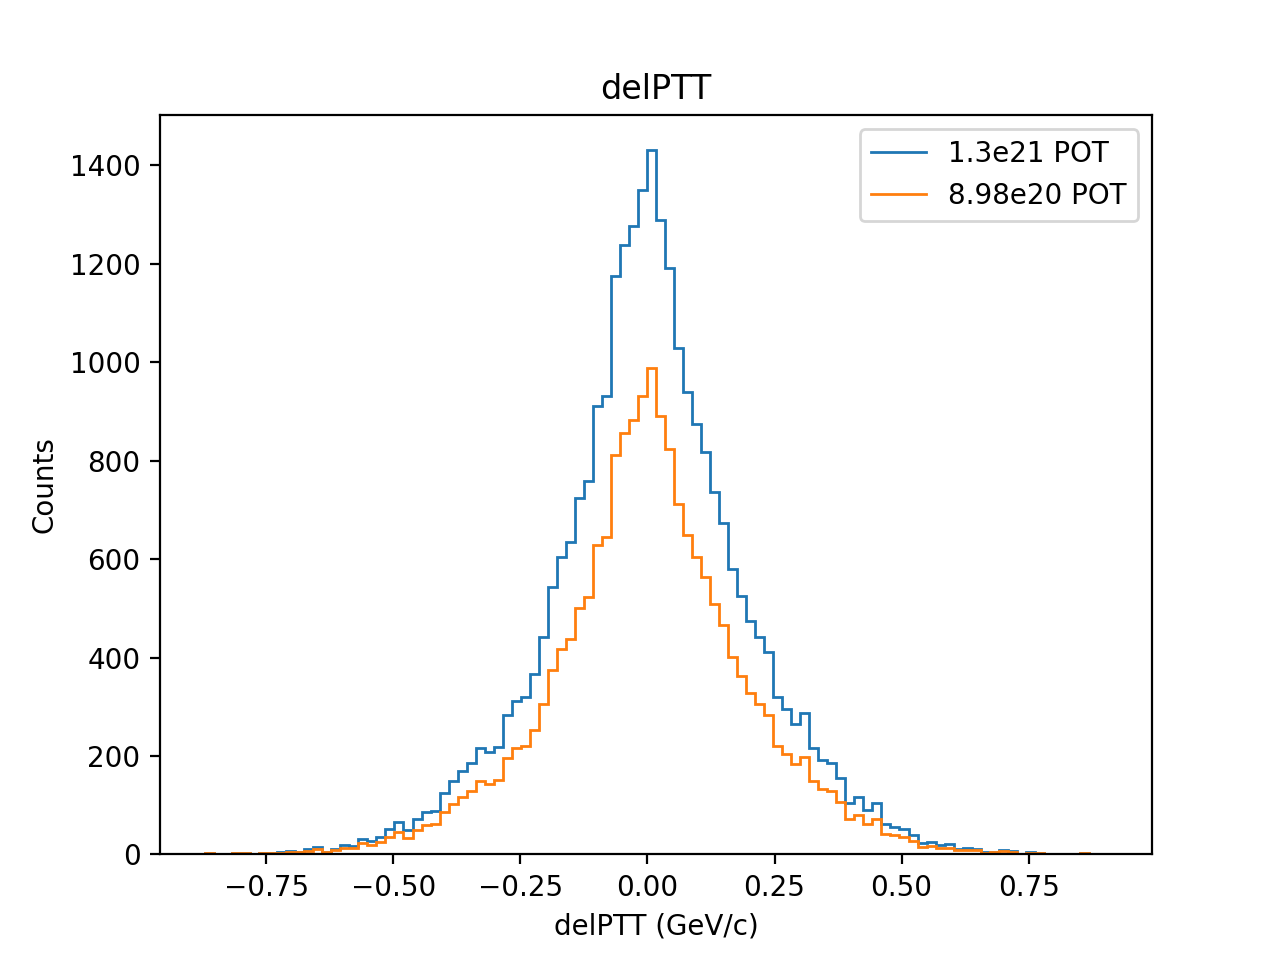

In [26]:
# delPTT everything together
# POT weighted

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#counts, bins = np.histogram(delPTT_arr, bins=100)
counts, bins = np.histogram(delPTT_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
#plt.hist(ntuple_muonMom, bins=100, weights=ntuple_weights)
plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('delPTT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


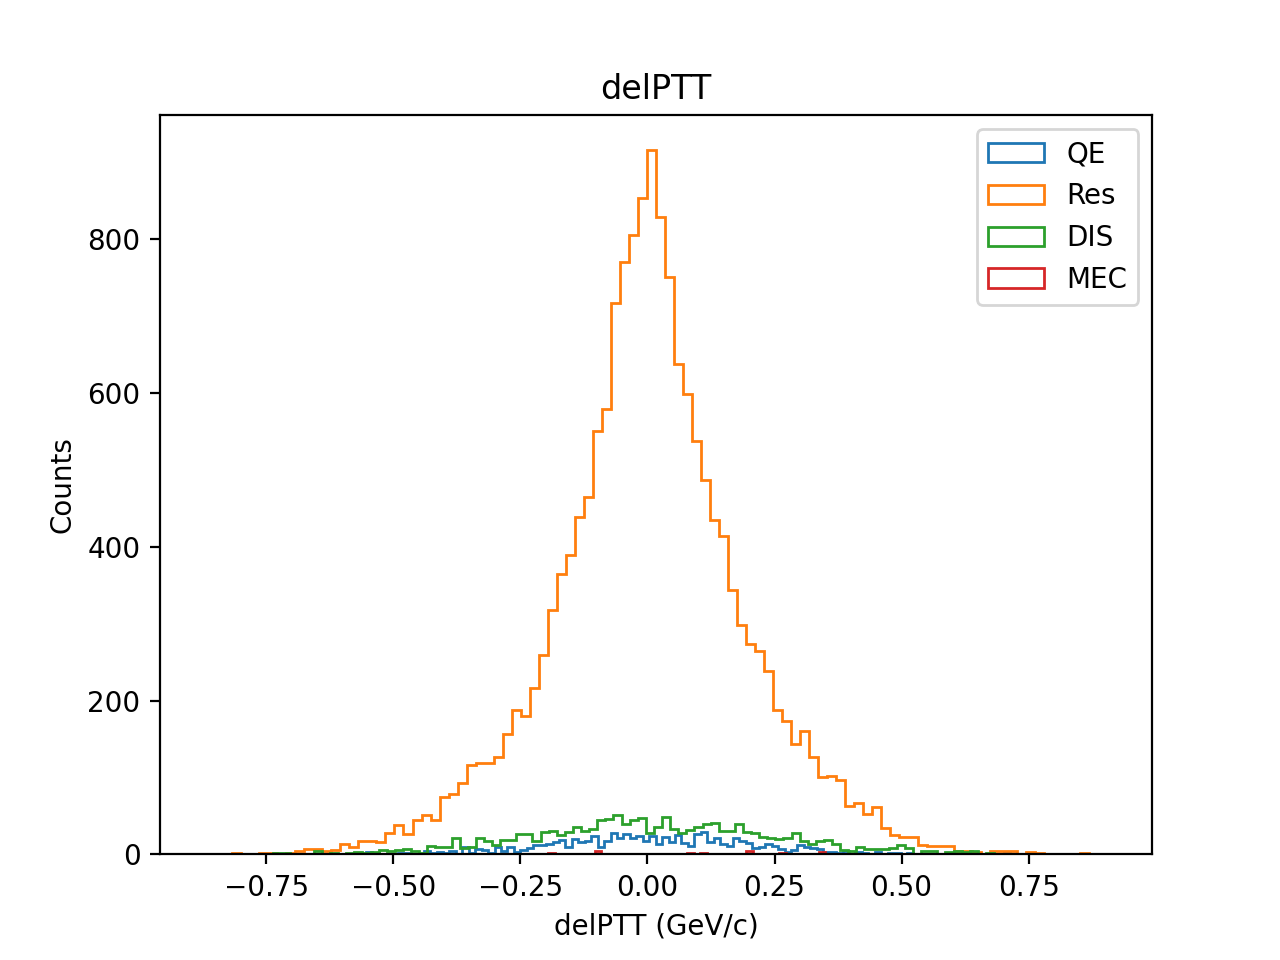

Text(0.5, 1.0, 'delPTT')

In [27]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#counts, bins = np.histogram(delPTT_arr, bins=100)
#ax.hist(delPTT_arr, bins=100, stacked=True, histtype='bar')
#ax.hist(delPTT_modeZero, bins=100, histtype='step', stacked=True, fill=False, label='QE')
ax.hist(delPTT_modeZero, bins=100, histtype='step', stacked=True, fill=False, weights=weights_modeZero, label='QE')
#ax.hist(delPTT_modeOne, bins=100, histtype='step', stacked=True, fill=False, label='Res')
ax.hist(delPTT_modeOne, bins=100, histtype='step', stacked=True, fill=False, weights=weights_modeOne, label='Res')
#ax.hist(delPTT_modeTwo, bins=100, histtype='step', stacked=True, fill=False, label='DIS')
ax.hist(delPTT_modeTwo, bins=100, histtype='step', stacked=True, fill=False, weights=weights_modeTwo, label='DIS')
#ax.hist(delPTT_modeTen, bins=100, histtype='step', stacked=True, fill=False, label='MEC')
ax.hist(delPTT_modeTen, bins=100, histtype='step', stacked=True, fill=False, weights=weights_modeTen, label='MEC')
#ax.hist(delPTT_arr, bins=100)
#plt.stairs(counts, bins)
plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.legend()
plt.title('delPTT')

<IPython.core.display.Javascript object>


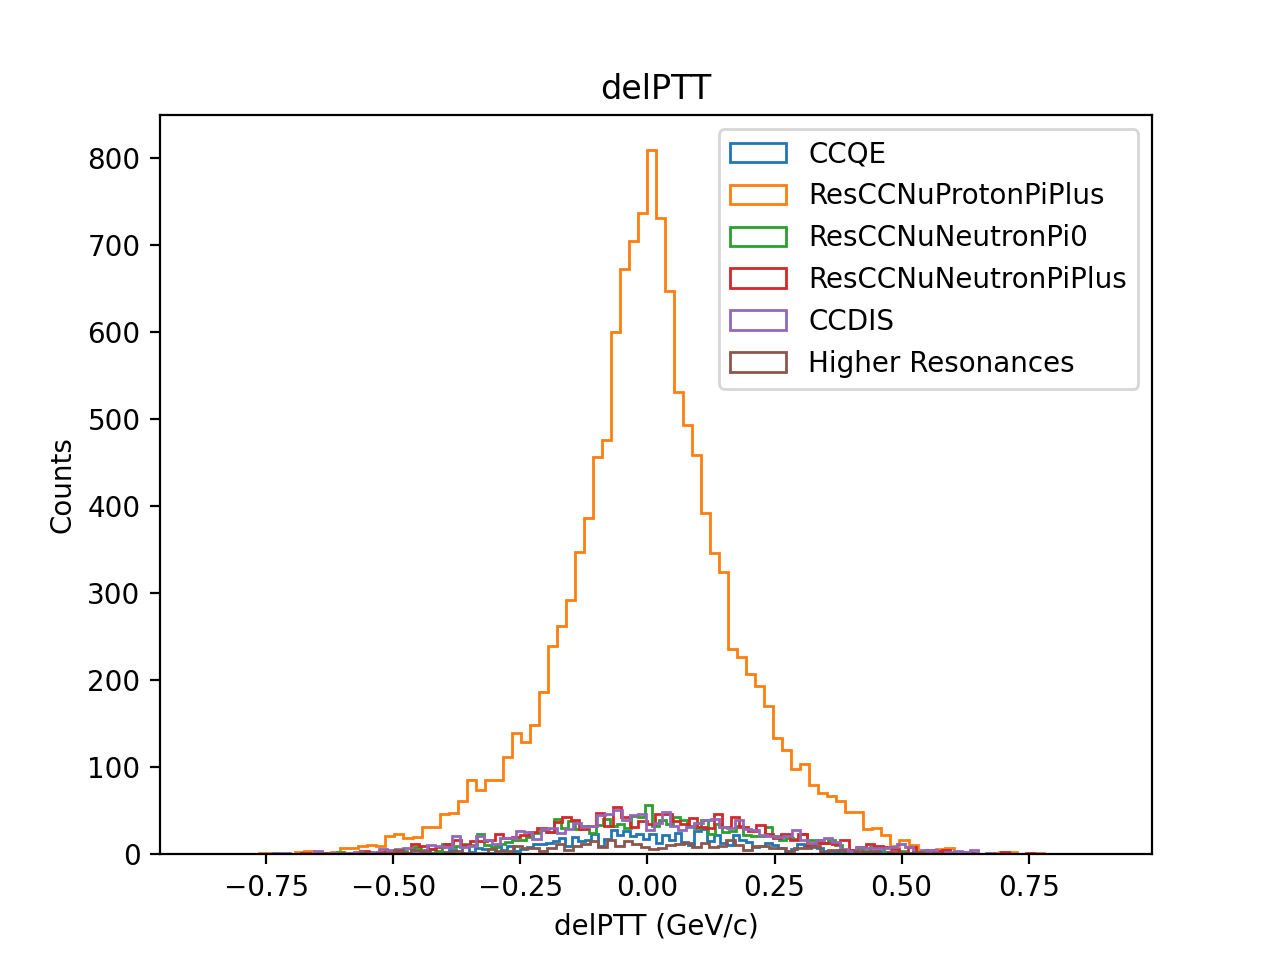

Text(0.5, 1.0, 'delPTT')

In [28]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#counts, bins = np.histogram(delPTT_arr, bins=100)
#ax.hist(delPTT_arr, bins=100, stacked=True, histtype='bar')
ax.hist(delPTT_intrxnB, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnB, label='CCQE')
ax.hist(delPTT_intrxnC, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnC, label='ResCCNuProtonPiPlus')
ax.hist(delPTT_intrxnD, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnD, label='ResCCNuNeutronPi0')
ax.hist(delPTT_intrxnE, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnE, label='ResCCNuNeutronPiPlus')
ax.hist(delPTT_intrxnF, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnF, label='CCDIS')
ax.hist(delPTT_intrxnA, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnA, label='Higher Resonances')
#ax.hist(delPTT_arr, bins=100)
#plt.stairs(counts, bins)
plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.legend()
plt.title('delPTT')

<IPython.core.display.Javascript object>


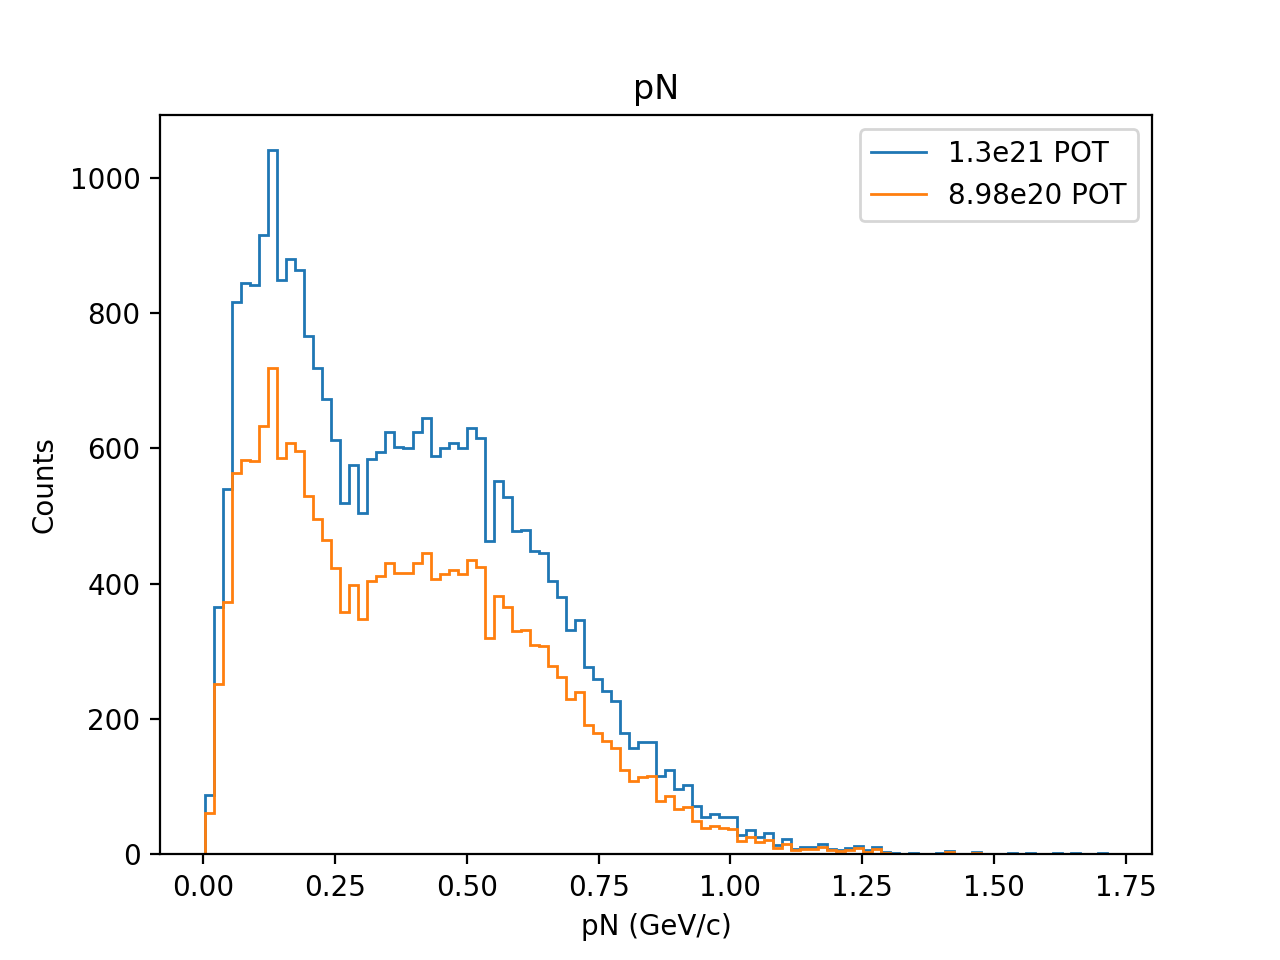

Text(0.5, 1.0, 'pN')

In [29]:
# pN everything together
# POT weighted

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(pN_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
#plt.hist(ntuple_muonMom, bins=100, weights=ntuple_weights)
plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.legend(loc="upper right")
plt.title('pN')

<IPython.core.display.Javascript object>


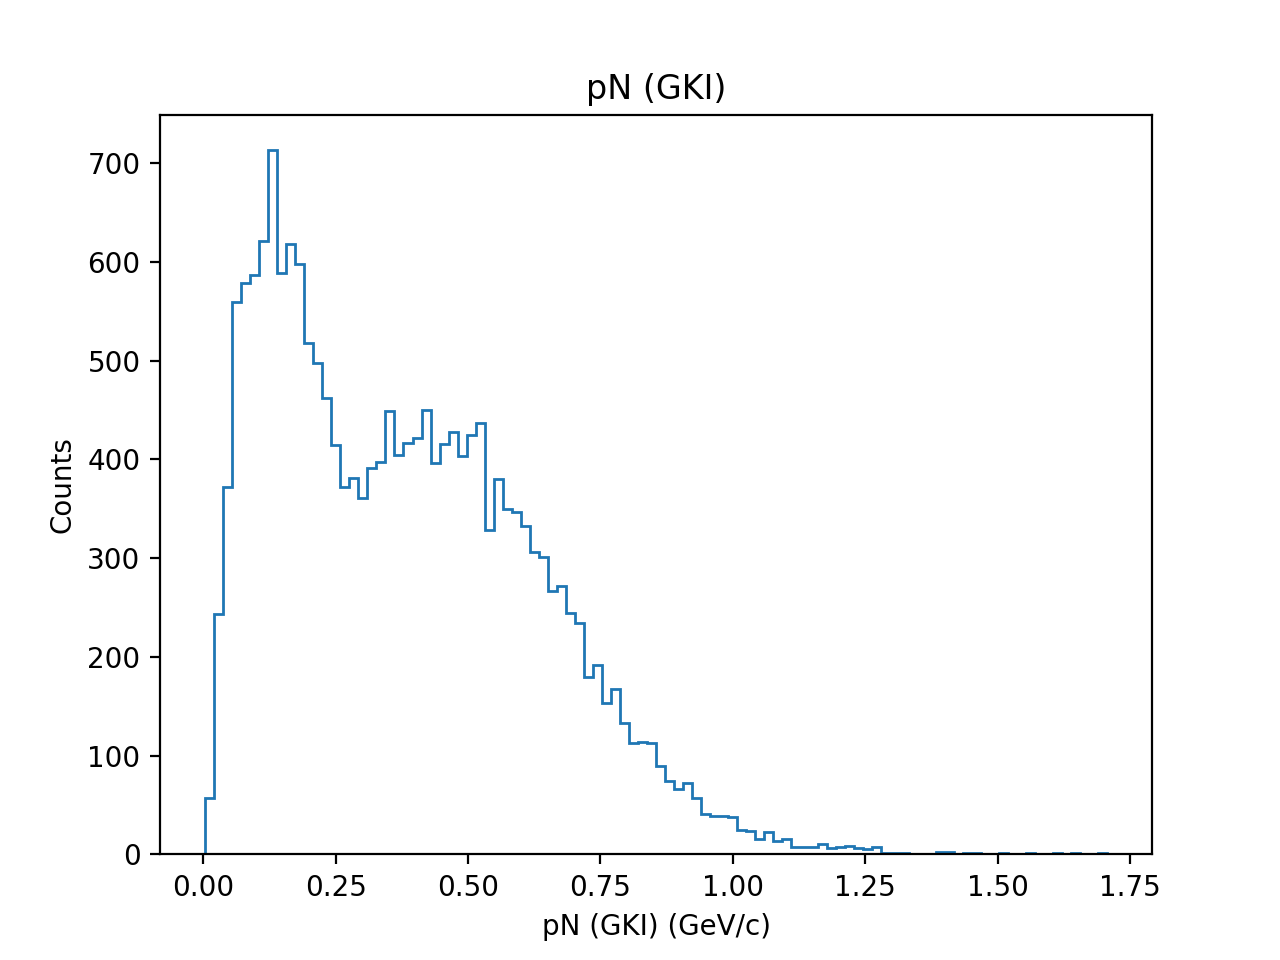

Text(0.5, 1.0, 'pN (GKI)')

In [30]:
# THIS IS THE GKI ONE

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(pNGKI_arr, bins=100)
plt.stairs(counts, bins)
plt.xlabel('pN (GKI) (GeV/c)')
plt.ylabel('Counts')
plt.title('pN (GKI)')

<IPython.core.display.Javascript object>


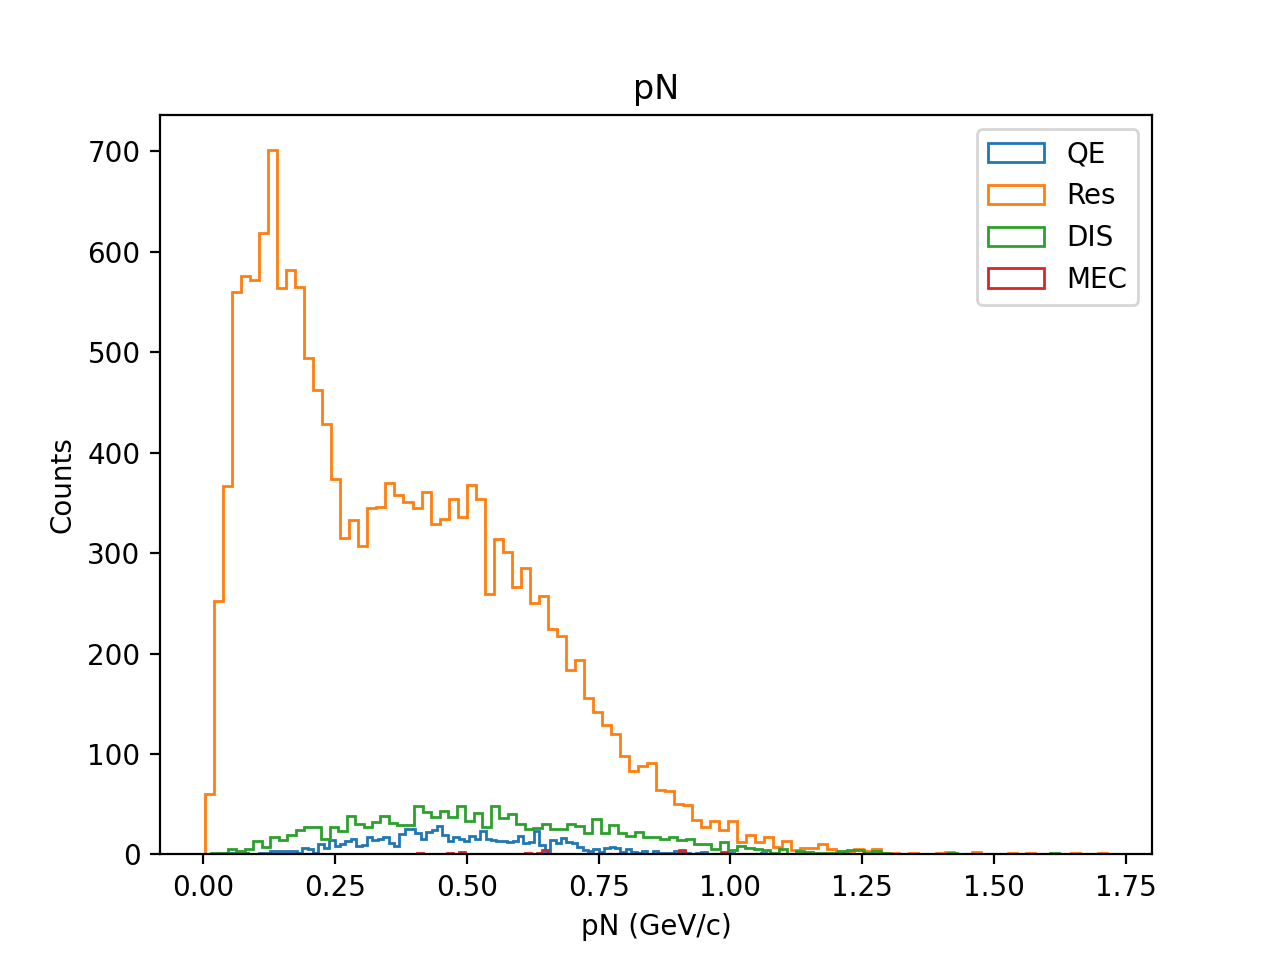

Text(0.5, 1.0, 'pN')

In [31]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#counts, bins = np.histogram(pN_arr, bins=100)
#counts, bins = np.histogram(pN_modeOne, bins=100)
#ax.hist(pN_arr, bins=100, histtype='step', stacked=True, fill=False)
ax.hist(pN_modeZero, bins=100, histtype='step', stacked=True, weights=weights_modeZero, fill=False, label='QE')
ax.hist(pN_modeOne, bins=100, histtype='step', stacked=True, weights=weights_modeOne, fill=False, label='Res')
ax.hist(pN_modeTwo, bins=100, histtype='step', stacked=True, weights=weights_modeTwo, fill=False, label='DIS')
ax.hist(pN_modeTen, bins=100, histtype='step', stacked=True, weights=weights_modeTen, fill=False, label='MEC')
#plt.stairs(counts, bins)
plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.legend()
plt.title('pN')

<IPython.core.display.Javascript object>


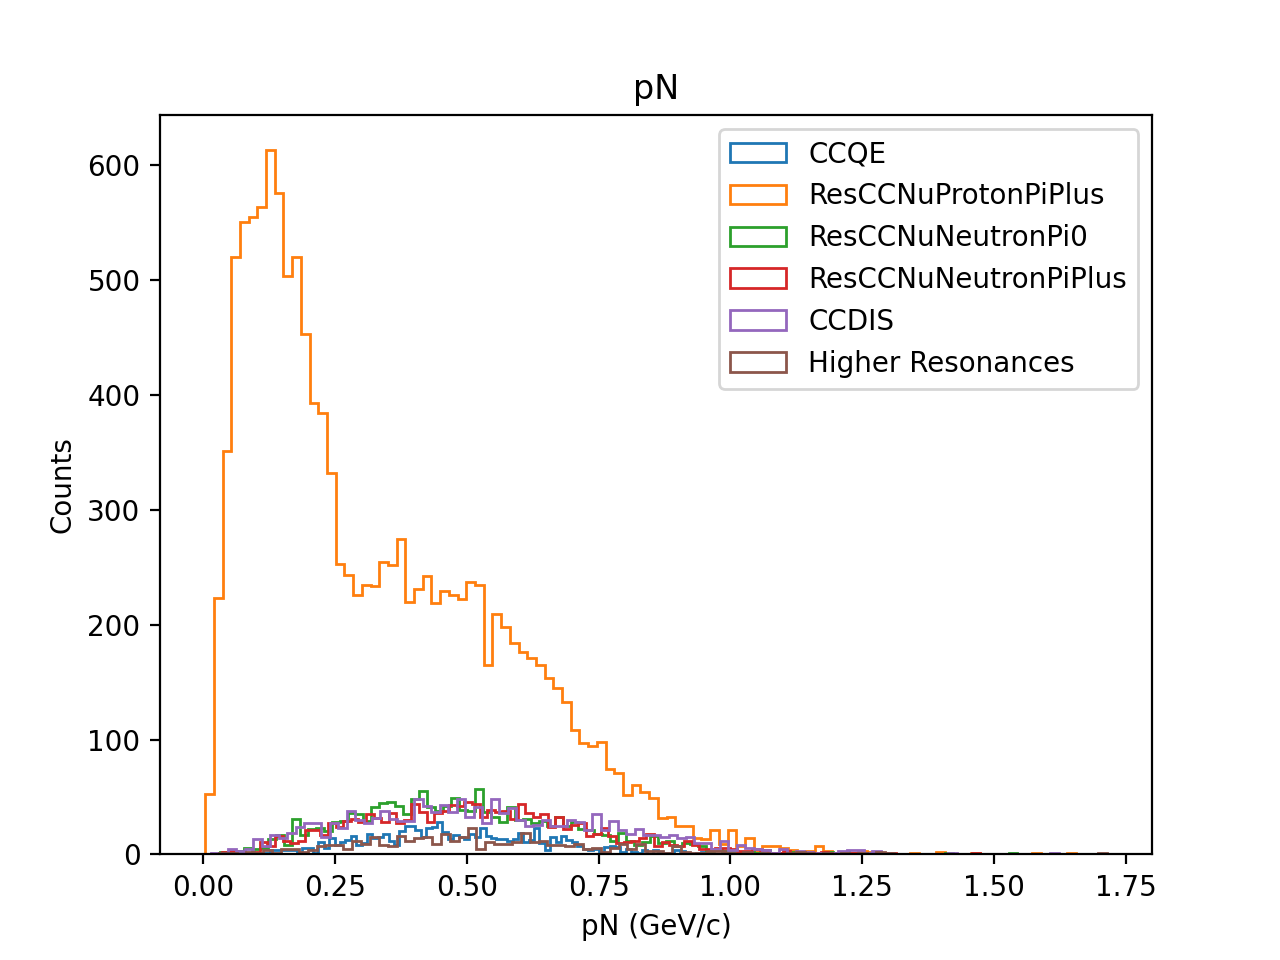

Text(0.5, 1.0, 'pN')

In [32]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.hist(pN_intrxnB, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnB, label='CCQE')
ax.hist(pN_intrxnC, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnC, label='ResCCNuProtonPiPlus')
ax.hist(pN_intrxnD, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnD, label='ResCCNuNeutronPi0')
ax.hist(pN_intrxnE, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnE, label='ResCCNuNeutronPiPlus')
ax.hist(pN_intrxnF, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnF, label='CCDIS')
ax.hist(pN_intrxnA, bins=100, histtype='step', stacked=True, fill=False, weights=weights_intrxnA, label='Higher Resonances')

plt.xlabel('pN (GeV/c)')
plt.ylabel('Counts')
plt.legend()
plt.title('pN')

<IPython.core.display.Javascript object>


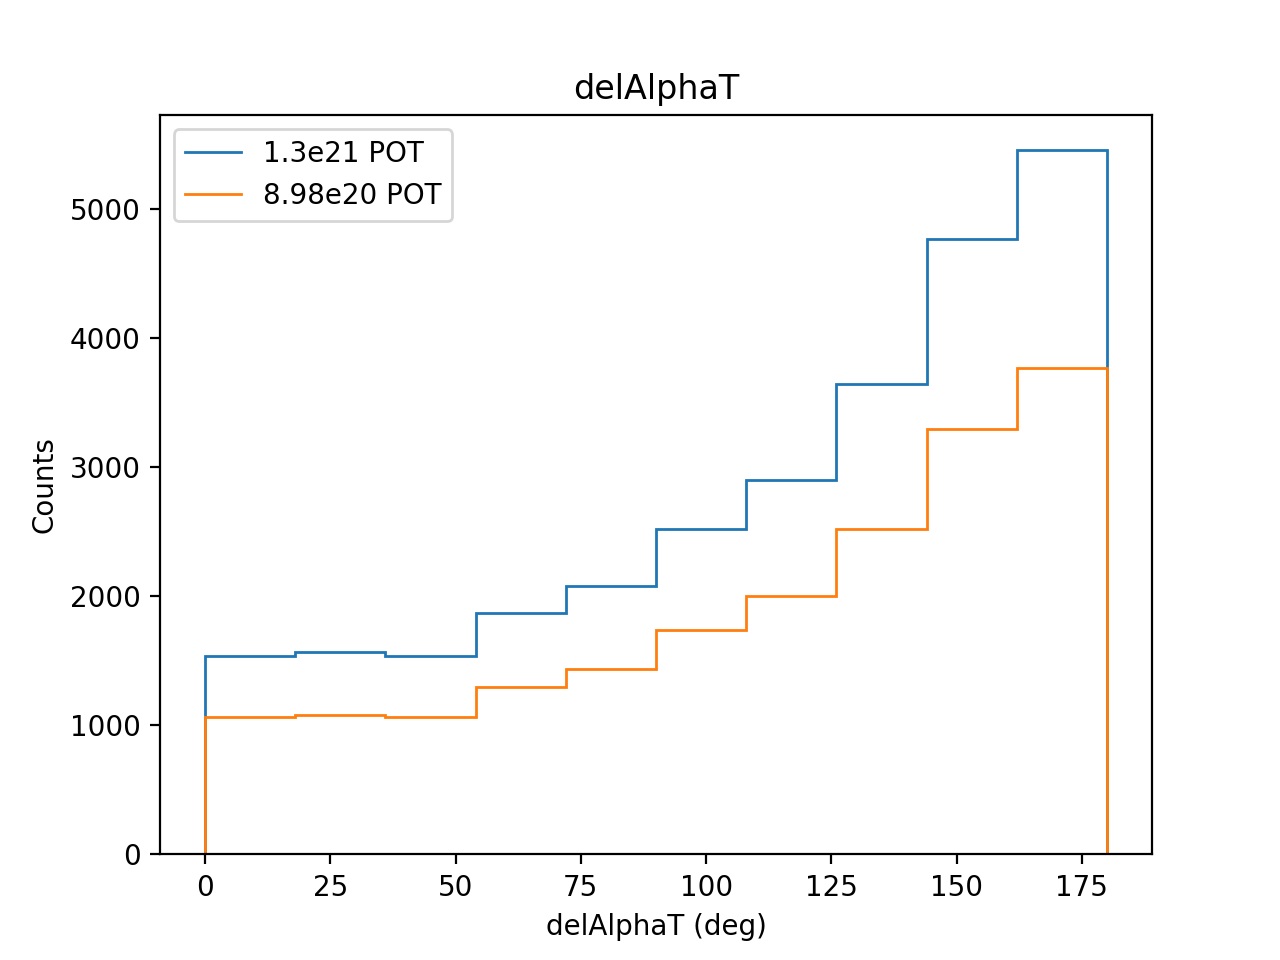

Text(0.5, 1.0, 'delAlphaT')

In [33]:
# delAlphaT everything together
# POT weighted

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(delAlphaT_deg, bins=10, weights=weights_arr)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
#plt.hist(ntuple_muonMom, bins=100, weights=ntuple_weights)
plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.legend(loc="upper left")
plt.title('delAlphaT')

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

<IPython.core.display.Javascript object>


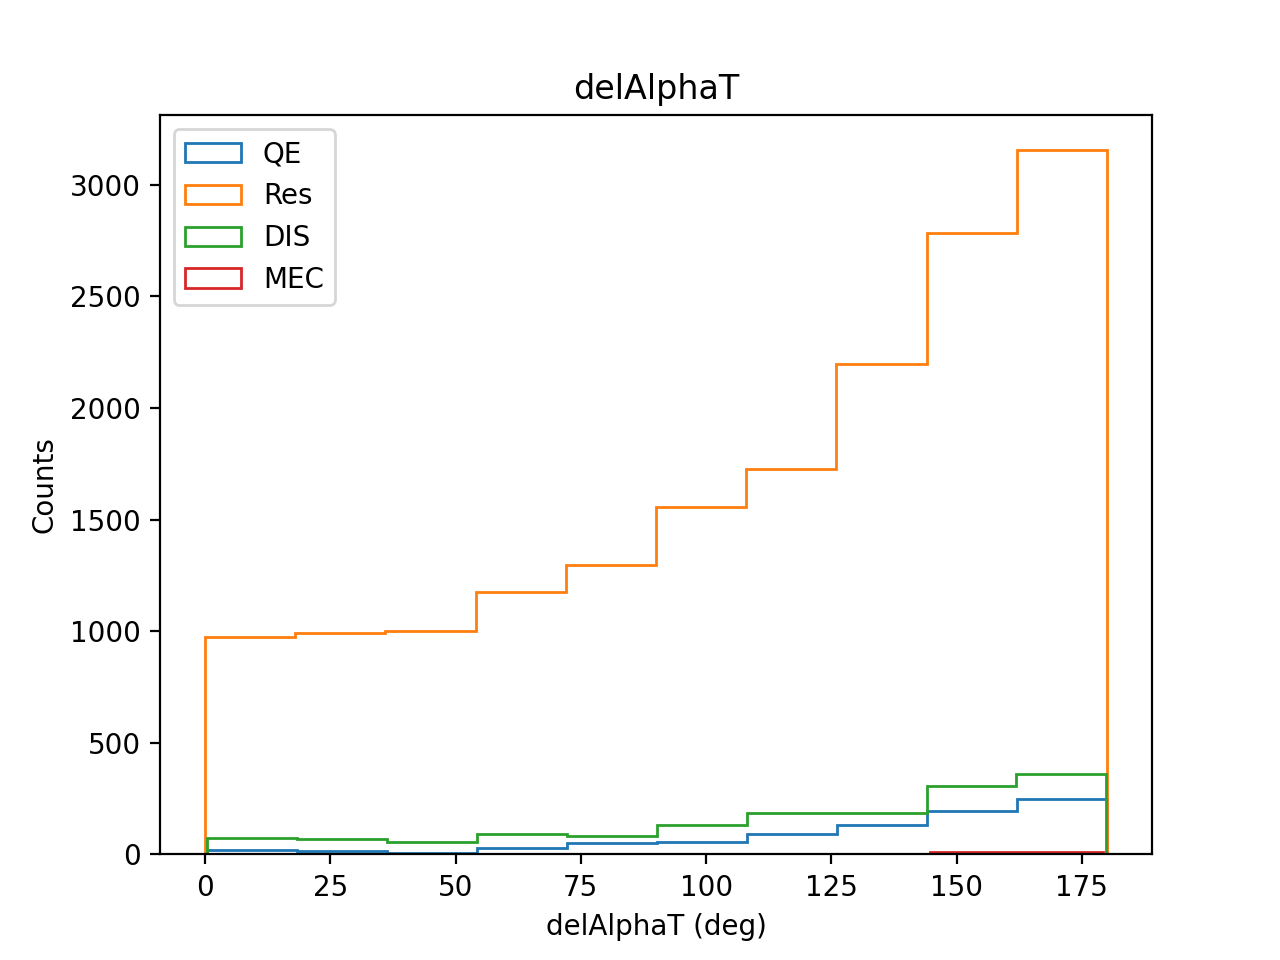

Text(0.5, 1.0, 'delAlphaT')

In [34]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)
#counts, bins = np.histogram(delAlphaT_deg, bins=10)
ax.hist(delAlphaT_modeZero, bins=10, histtype='step', stacked=True, fill=False, weights=weights_modeZero, label='QE')
ax.hist(delAlphaT_modeOne, bins=10, histtype='step', stacked=True, fill=False, weights=weights_modeOne, label='Res')
ax.hist(delAlphaT_modeTwo, bins=10, histtype='step', stacked=True, fill=False, weights=weights_modeTwo, label='DIS')
ax.hist(delAlphaT_modeTen, bins=10, histtype='step', stacked=True, fill=False, weights=weights_modeTen, label='MEC')
#plt.stairs(counts, bins)
plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.legend(loc="upper left")
plt.title('delAlphaT')

<IPython.core.display.Javascript object>


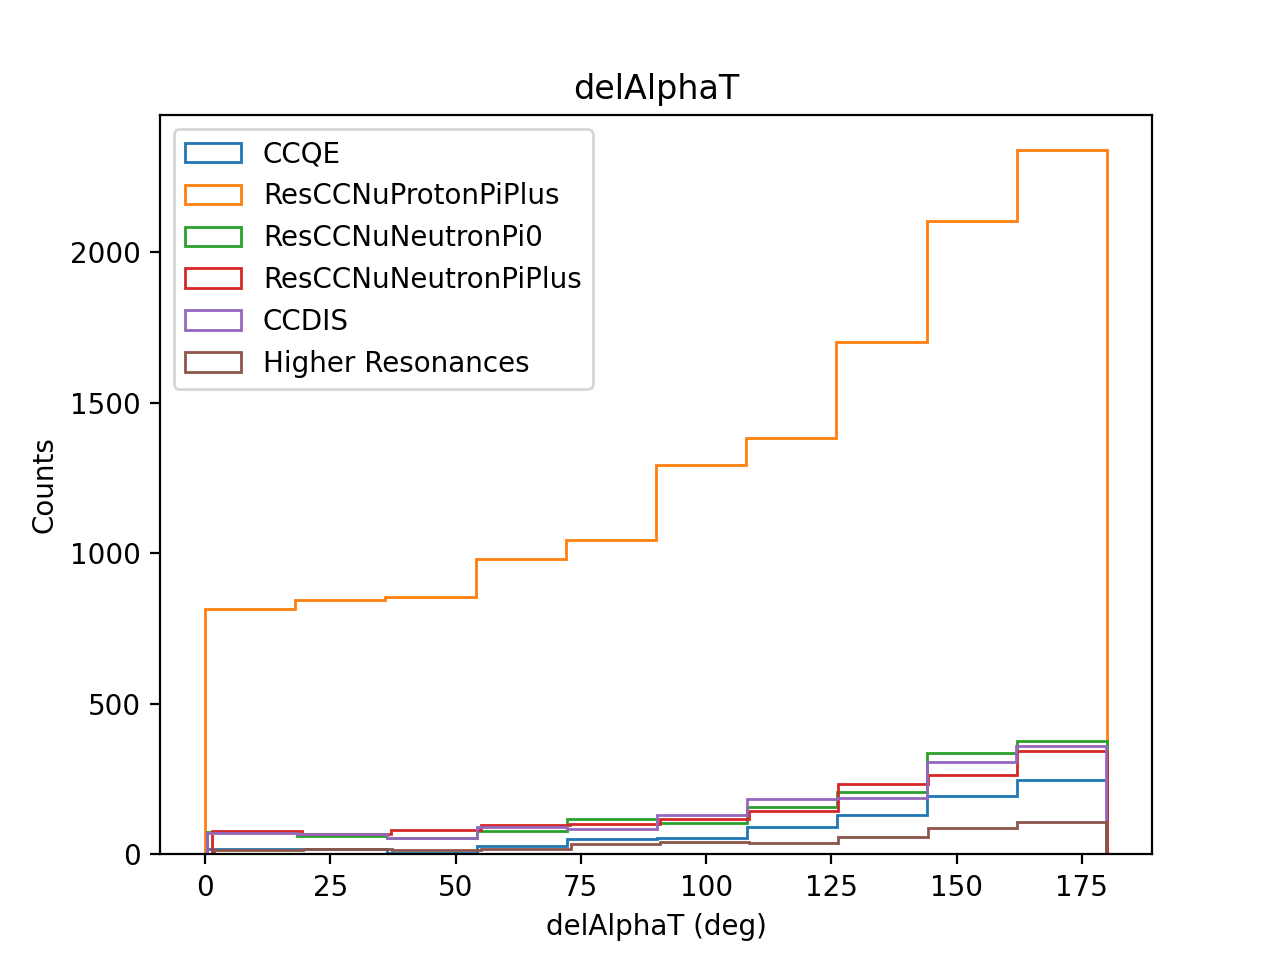

Text(0.5, 1.0, 'delAlphaT')

In [35]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.hist(delAlphaT_intrxnB, bins=10, histtype='step', stacked=True, fill=False, weights=weights_intrxnB, label='CCQE')
ax.hist(delAlphaT_intrxnC, bins=10, histtype='step', stacked=True, fill=False, weights=weights_intrxnC, label='ResCCNuProtonPiPlus')
ax.hist(delAlphaT_intrxnD, bins=10, histtype='step', stacked=True, fill=False, weights=weights_intrxnD, label='ResCCNuNeutronPi0')
ax.hist(delAlphaT_intrxnE, bins=10, histtype='step', stacked=True, fill=False, weights=weights_intrxnE, label='ResCCNuNeutronPiPlus')
ax.hist(delAlphaT_intrxnF, bins=10, histtype='step', stacked=True, fill=False, weights=weights_intrxnF, label='CCDIS')
ax.hist(delAlphaT_intrxnA, bins=10, histtype='step', stacked=True, fill=False, weights=weights_intrxnA, label='Higher Resonances')

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.legend(loc="upper left")
plt.title('delAlphaT')

<IPython.core.display.Javascript object>


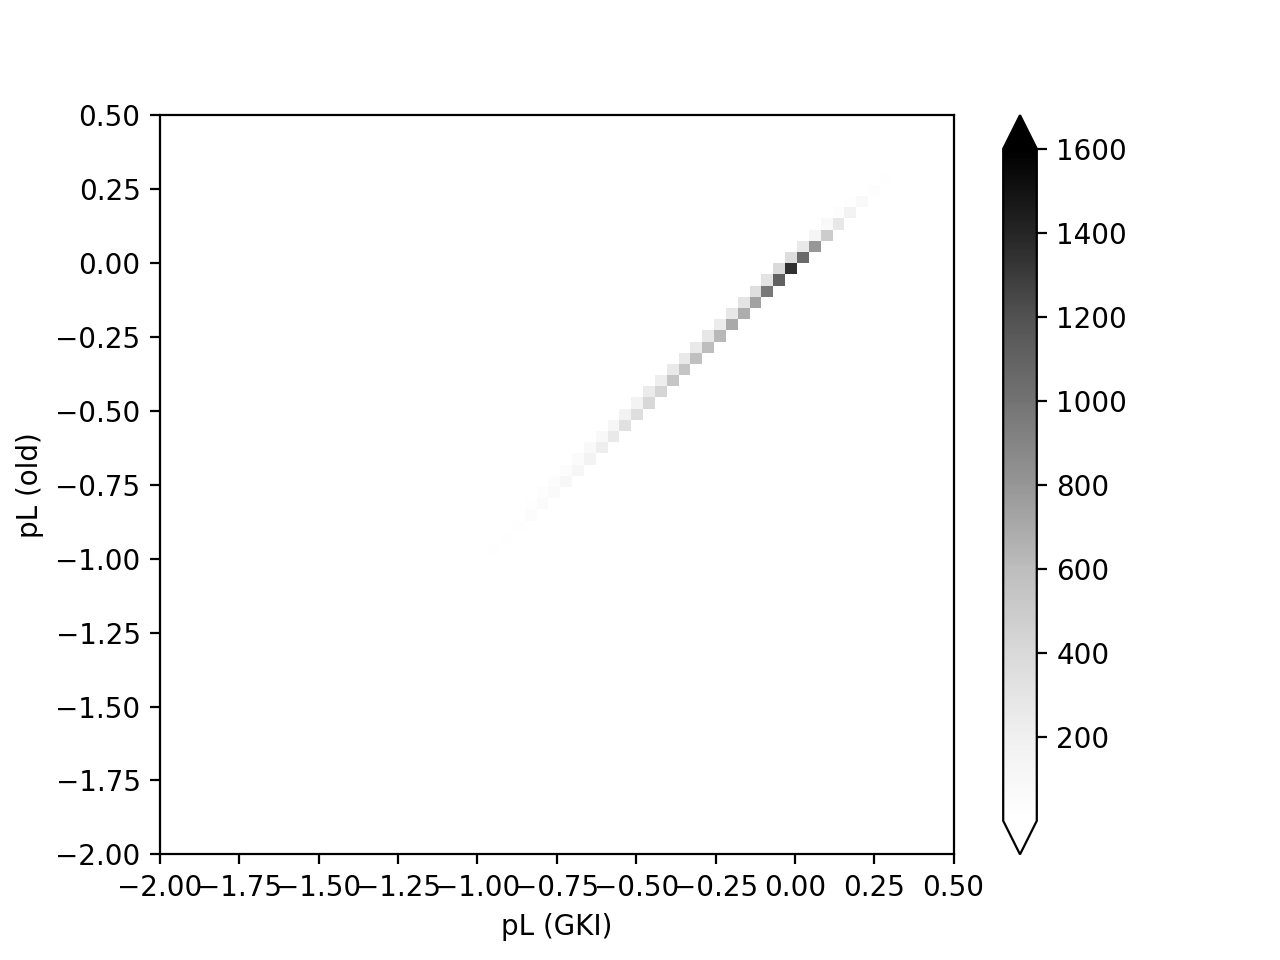

In [36]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#x, y = np.histogram2d(pL_arr, pLGKI_arr)

#pL_arr[pL_arr==0] = np.NaN
#pLGKI_arr[pLGKI_arr==0] = np.NaN

#matplotlib axes are x, y
plt.hist2d(pLGKI_arr, pL_arr, bins=(50, 50), cmap=plt.cm.Greys)
#plt.hist2d(pLGKI_arr, pL_arr, bins=(50, 50), range=np.array([(-1, 1), (-1, 1)]), cmap=plt.cm.jet)
plt.show()
#xlim([-6, 6])
#ylim([-4.5, 4.5])
#plt.imshow(x,y)
#plt.stairs(x, y)
#ax.set(xlim=(-2, 2), ylim=(-2, 2))
plt.xlabel('pL (GKI)')
ax.set_yticks([-2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50]) 
ax.set_xticks([-2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50]) 
plt.ylabel('pL (old)')
plt.colorbar(extend='both')
plt.clim(1, 1600);
#plt.title('delAlphaT')

<IPython.core.display.Javascript object>


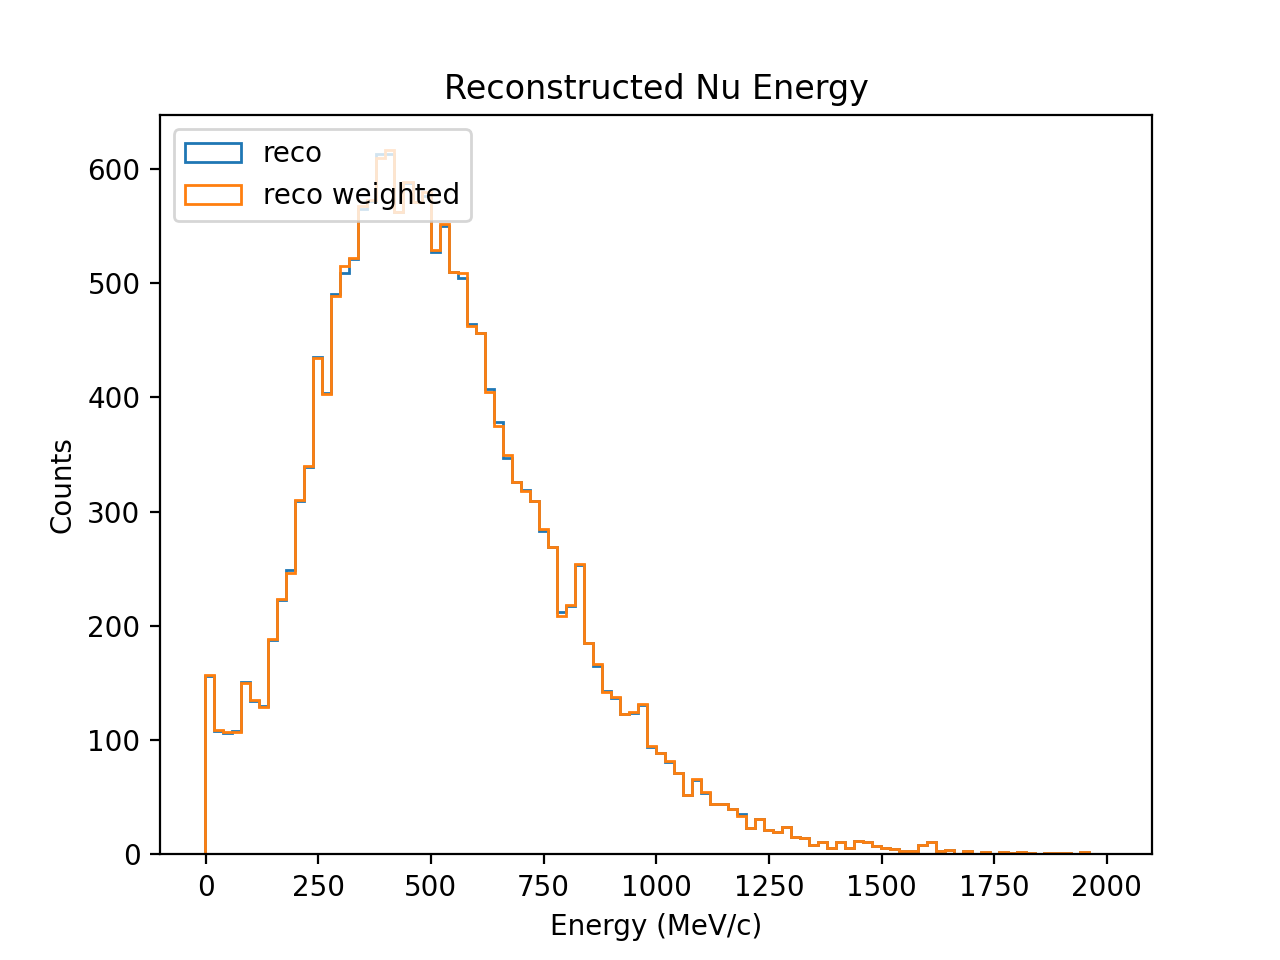

Text(0.5, 1.0, 'Reconstructed Nu Energy')

In [37]:
ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)
#counts, bins = np.histogram(delAlphaT_deg, bins=10)
ax.hist(recoNuE_arr, range=[-1, 2000], bins=100, histtype='step', stacked=True, fill=False, label='reco')
ax.hist(recoNuE_arr, range=[-1, 2000], bins=100, histtype='step', stacked=True, fill=False, weights=weights_arr, label='reco weighted')
#ax.hist(delAlphaT_modeOne, bins=100, histtype='step', stacked=True, fill=False, label='Res')
#ax.hist(delAlphaT_modeTwo, bins=100, histtype='step', stacked=True, fill=False, label='DIS')
#ax.hist(delAlphaT_modeTen, bins=100, histtype='step', stacked=True, fill=False, label='MEC')
#plt.stairs(counts, bins)
plt.xlabel('Energy (MeV/c)')
plt.ylabel('Counts')
plt.legend(loc="upper left")
plt.title('Reconstructed Nu Energy')

In [38]:
h = ROOT.TH1F("gauss","Example histogram",100,-4,4)
h.FillRandom("gaus")

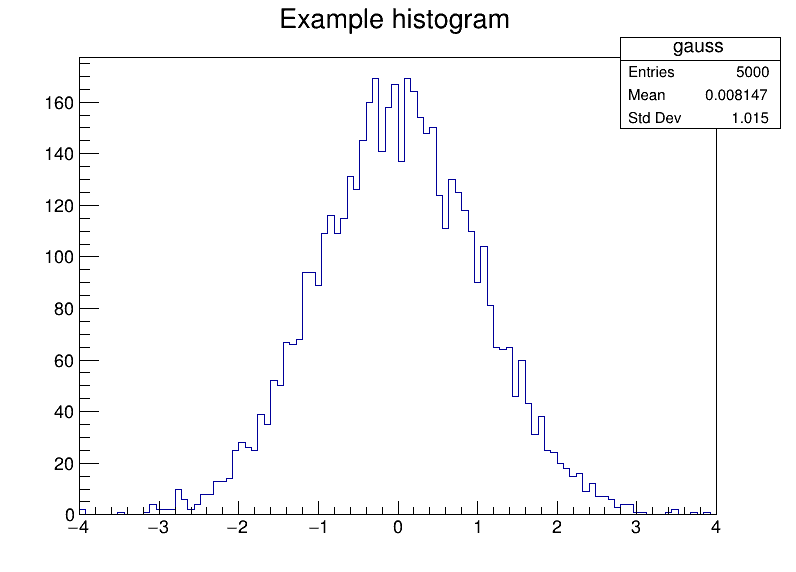

In [39]:
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
h.Draw()
c.Draw()

In [40]:
targetPOT = 1.3e21
sumPOT = 8.98e20

scale = targetPOT / sumPOT
print("Scale is: ", scale)

print(np.sum(weights_list))
totalEvents = np.sum(weights_list)*scale
print("totalEvents: ", totalEvents)

Scale is:  1.447661469933185
19260.782968604184
totalEvents:  27883.093384393585


## POT Weighted Momentum Plots

<IPython.core.display.Javascript object>


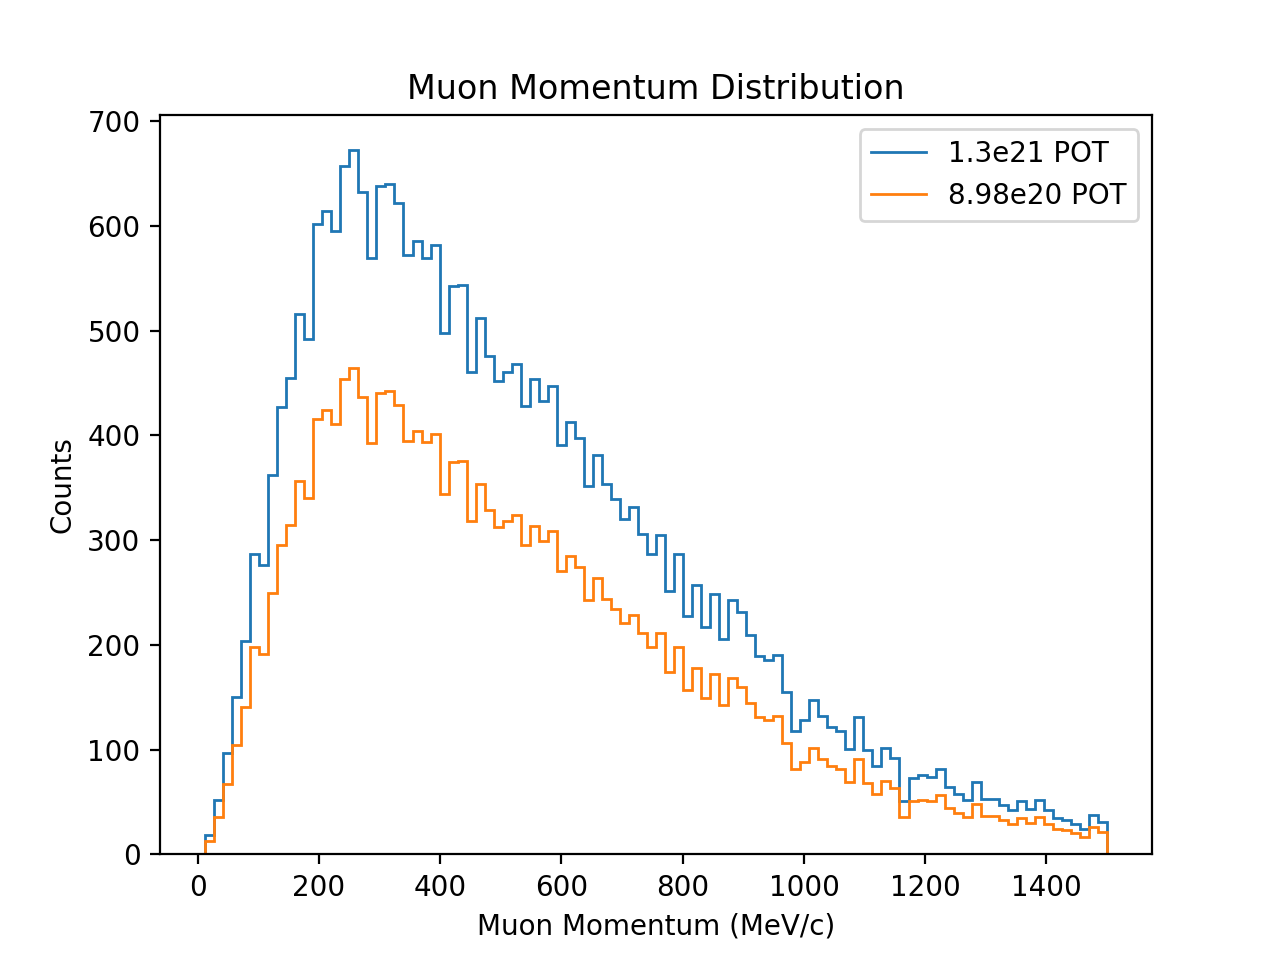

In [47]:
# muon mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

#counts, bins = np.histogram(delPTT_arr, bins=100)
counts, bins = np.histogram(muMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale
plt.stairs(scaledCounts, bins, label="1.3e21 POT")
plt.stairs(counts, bins, label="8.98e20 POT")
#plt.hist(ntuple_muonMom, bins=100, weights=ntuple_weights)
plt.xlabel('Muon Momentum (MeV/c)')
plt.ylabel('Counts')
plt.title('Muon Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)